In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        

In [2]:
input_path = './data/'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

In [3]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

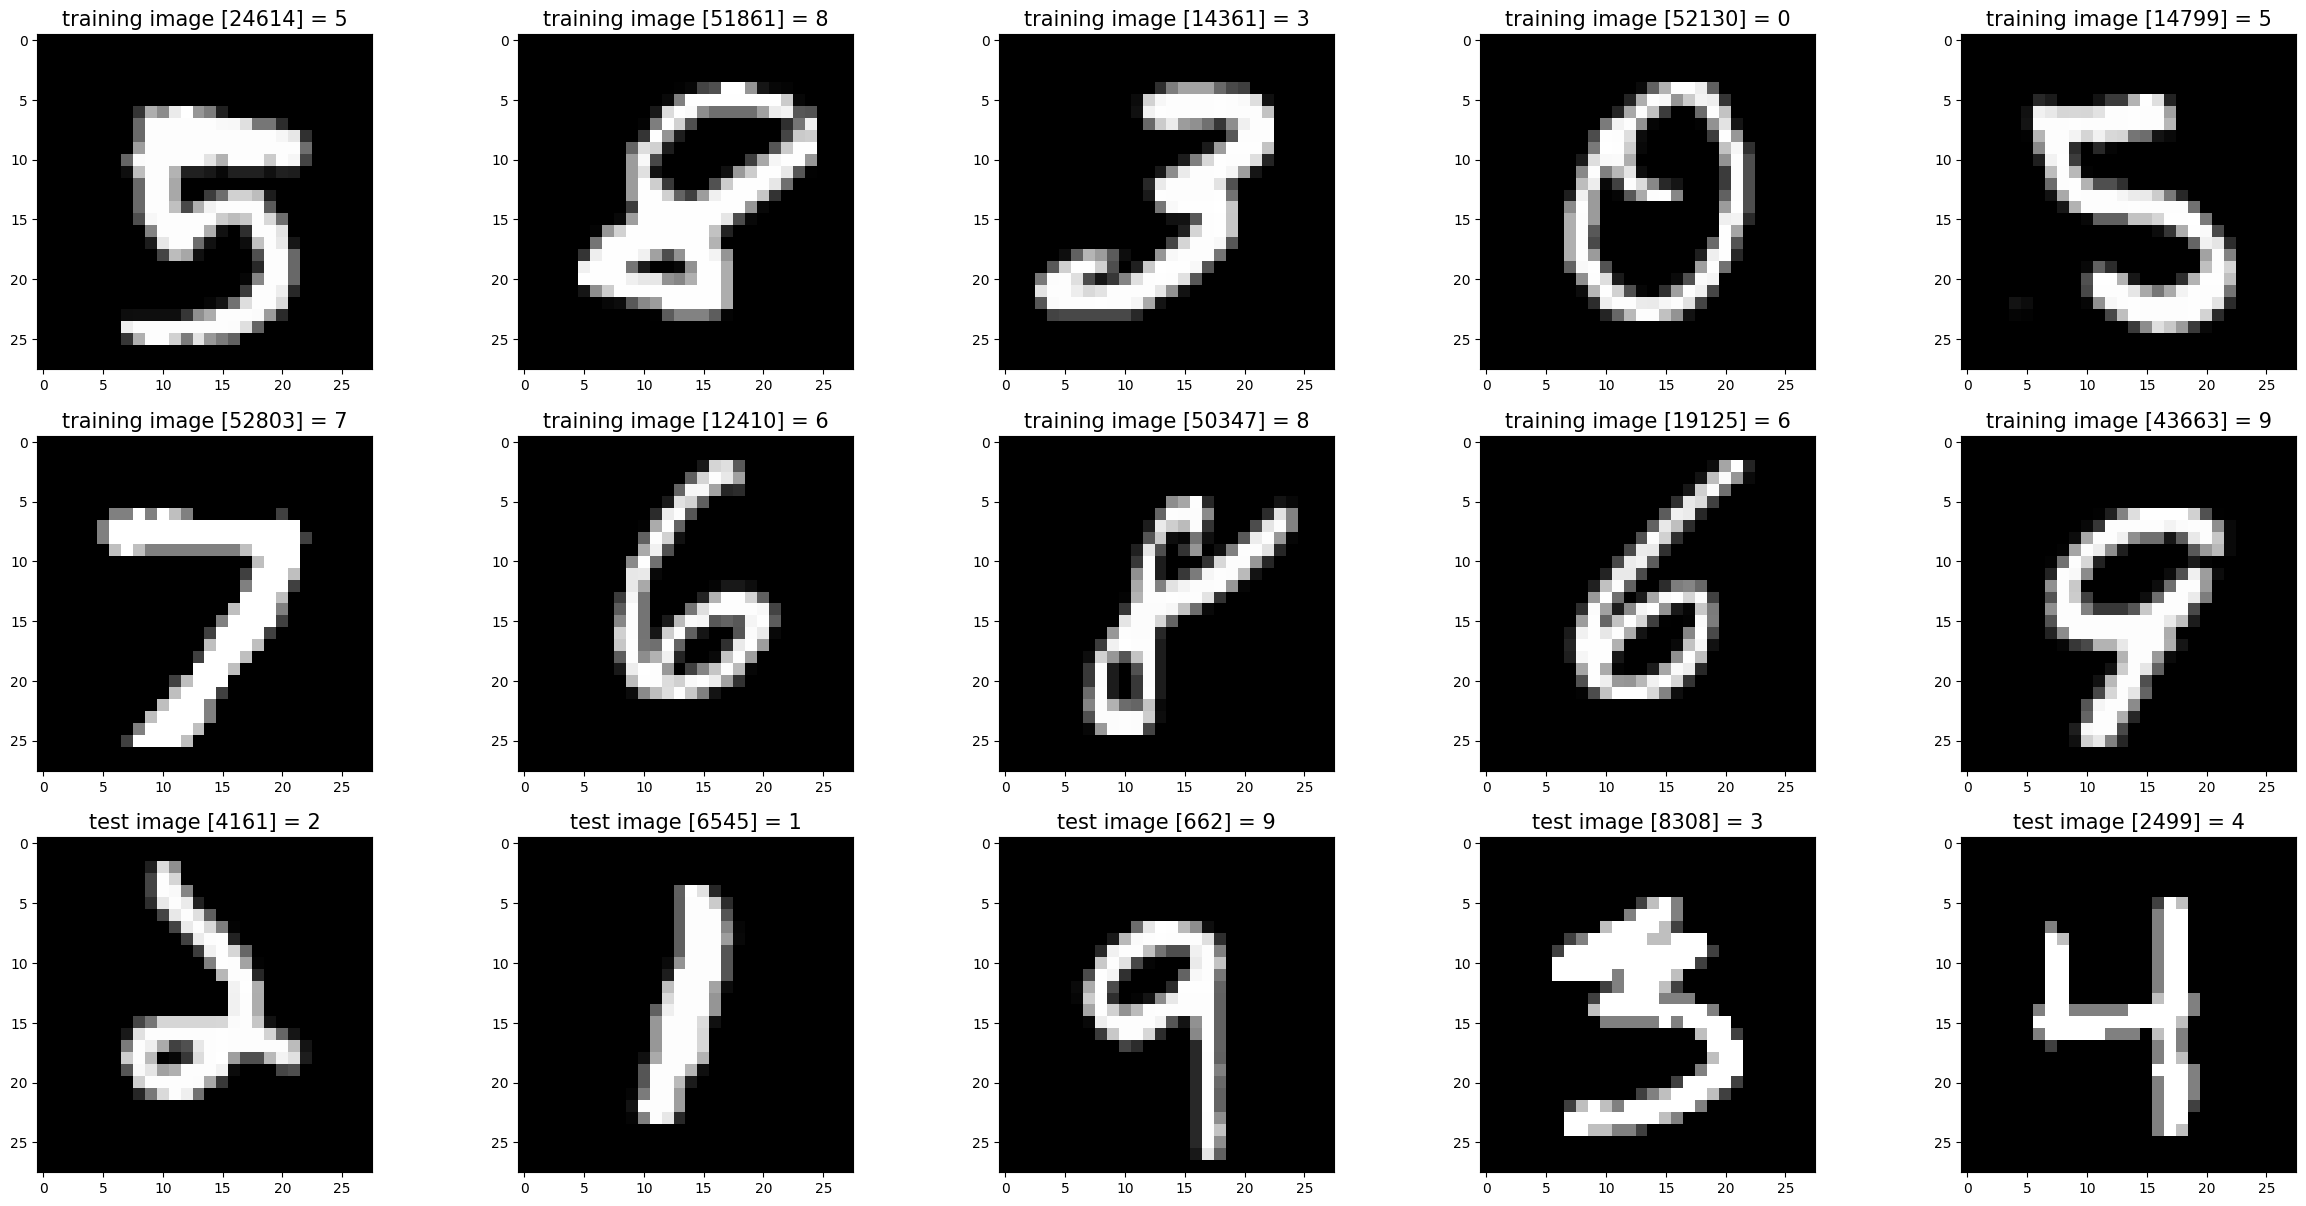

In [4]:
#
# Helper function to show a list of images with their relating titles
#
import random
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [5]:
print(f"Images are {len(x_train[0][0])} x {len(x_train[0])} which is a total of {len(x_train[0][0]) * len(x_train[0])} pixels per image.")

Images are 28 x 28 which is a total of 784 pixels per image.


In [6]:
inputs_len = len(x_train[0][0]) * len(x_train[0])
x_train_processed = np.empty([len(x_train), inputs_len])
y_train_processed = np.asarray(y_train)
for index, _ in enumerate(x_train):
    x_train_processed[index] = np.asarray(x_train[index]).flatten()
display(f"X shape: {x_train_processed.shape}")
display(f"y shape: {y_train_processed.shape}")

'X shape: (60000, 784)'

'y shape: (60000,)'

In [7]:
class NN:
    def __init__(self, x_train, y_train, layers):
        self.x = x_train
        self.y = y_train
        self.input_neurons = self.x.shape[1]  # Number of features in the input dataset
        self.output_neurons = 1
        self.weights_hidden_layers = []
        if len(layers) > 0:
            print(f"Creating input weights: inputs = {self.input_neurons} outputs = {layers[0]['neurons']}")
            self.weights_hidden_input = 2 * np.random.random((self.input_neurons, layers[0]["neurons"])) - 1
        else:
            print(f"Creating input weights: inputs = {self.input_neurons} outputs = {self.output_neurons}")
            self.weights_hidden_input = 2 * np.random.random((self.input_neurons, self.output_neurons)) - 1
        for i, _ in enumerate(layers):
            print(f"Adding hidden layer weights: inputs = {layers[i-1]['neurons']} outputs = {layers[i]['neurons']}")
            self.weights_hidden_layers.append(2 * np.random.random((layers[i-1]["neurons"], layers[i]["neurons"])) - 1)
        self.weights_hidden_layers = np.array(self.weights_hidden_layers)
        if len(layers) > 0:
            print(f"Creating output weights: inputs = {layers[-1]['neurons']} outputs = {self.output_neurons}")
            self.weights_hidden_output = 2 * np.random.random((layers[-1]["neurons"], self.output_neurons)) - 1
        else:
            print(f"Creating output weights: inputs = {self.input_neurons} outputs = {self.output_neurons}")
            self.weights_hidden_output = 2 * np.random.random((self.input_neurons, self.output_neurons)) - 1

    def create_layer(neurons: int):
        return {"neurons": neurons}
    
    def relu(self, x: float) -> float:
        return np.maximum(0, x)
    
    def relu_derivation(self, x: float) -> int:
        return np.where(x > 0, 1, 0)
    
    def train(self, epochs=10):
        for epoch in range(epochs):
            
            # Forward propagation
            print(f"Epoch: {epoch+1}")
            input_layer = self.x
            hidden_layers = []
            hidden_layers.append(self.relu(np.dot(input_layer, self.weights_hidden_input)))
            for index, layer_weights in enumerate(self.weights_hidden_layers):
               hidden_layers.append(self.relu(np.dot(hidden_layers[index-1], layer_weights)))
            hidden_layers.append(self.relu(np.dot(hidden_layers[-1], self.weights_hidden_output)))
            
            # Backward propagation
            output_layer_error = self.y - hidden_layers[-1]
            output_layer_delta = output_layer_error * self.relu_derivation(hidden_layers[-1])
            

In [8]:
my_nn = NN(x_train_processed, y_train_processed, [
    NN.create_layer(3),
    NN.create_layer(3)
])

Creating input weights: inputs = 784 outputs = 3
Adding hidden layer weights: inputs = 3 outputs = 3
Adding hidden layer weights: inputs = 3 outputs = 3
Creating output weights: inputs = 3 outputs = 1


In [9]:
display(my_nn.weights_hidden_input.shape)
display(my_nn.weights_hidden_output.shape)
display(my_nn.weights_hidden_layers.shape)

(784, 3)

(3, 1)

(2, 3, 3)

In [10]:
my_nn.train(epochs=3)

Epoch: 1
Output Layer delta: [[-210.68020822 -215.68020822 -211.68020822 ... -210.68020822
  -209.68020822 -207.68020822]
 [-175.37553494 -180.37553494 -176.37553494 ... -175.37553494
  -174.37553494 -172.37553494]
 [   2.03681736   -2.96318264    1.03681736 ...    2.03681736
     3.03681736    5.03681736]
 ...
 [-295.89591604 -300.89591604 -296.89591604 ... -295.89591604
  -294.89591604 -292.89591604]
 [ -44.78237638  -49.78237638  -45.78237638 ...  -44.78237638
   -43.78237638  -41.78237638]
 [-162.71756944 -167.71756944 -163.71756944 ... -162.71756944
  -161.71756944 -159.71756944]]
Epoch: 2


KeyboardInterrupt: 